In [1]:
# %%sh
# git clone https://github.com/jcboyd/multi-cell-line.git
# ln -s multi-cell-line/src

In [2]:
import os
import sys
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils import *
from src.lococv import construct_profiles, lococv
from src.feature_reader import FeatureReader
from src.vis_utils import image_crop_training_set

data_path = 'multi-cell-line/cecog_out_propagate_0.5'
metadata_file = 'multi-cell-line/PlateMap-KPP_MOA.xlsx'
df_metadata = pd.read_excel(metadata_file).set_index('well')

# Create drug type column
df_metadata.loc[df_metadata['content'] != 'DMSO', 'category'] = 'Perturbation'
df_metadata.loc[df_metadata['content'] == 'DMSO', 'category'] = 'DMSO'
df_metadata.loc[df_metadata['content'] == 'None', 'category'] = 'None'
df_metadata.loc[df_metadata['content'] == 'Olaparib', 'category'] = 'Positive'
df_metadata.loc[df_metadata['content'] == 'Cisplatine', 'category'] = 'Positive'

# Remove drugs
df_metadata = df_metadata.drop(df_metadata[df_metadata['moa'] == 'Wild'].index)

# Remove wells without content
df_metadata = df_metadata[~df_metadata.content.isnull()]

channels = ['primary__primary4', 'secondary__propagate', 'tertiary__expanded']
plates = {'mda231' : '22_384_20X-hNA_D_F_C3_C5_20160031_2016.01.25.17.23.13_MDA231',
          'mda468' : '22_384_20X-hNA_D_F_C3_C5_20160032_2016.01.25.16.27.22_MDA468'}

plate_data = {}

for cell_line in plates.keys():
    
    ch5_path = '%s/%s/hdf5/' % (data_path, plates[cell_line])

    # read handcrafted features
    fr = FeatureReader(plates[cell_line], ch5_path, channels, cell_line)
    fr.read_all()
    fr.data['cell_line'] = cell_line
    plate_data[cell_line] = fr

    problem_feature = 'primary__primary4_dyn_distance_radius_3'
    fr.data = fr.data.drop(problem_feature, axis=1)
    fr.feature_names.remove(problem_feature)

    # Join metadata
    fr.join_plate_map(df_metadata.reset_index())
    fr.data = fr.data[~fr.data['content'].isnull()]

Using TensorFlow backend.
/Users/hclimente/miniconda3/envs/laptop/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/hclimente/miniconda3/envs/laptop/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/hclimente/miniconda3/envs/laptop/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/User

Reading cell data...
Reading cell centers...
Reading primary__primary4 features...
Reading secondary__propagate features...
Reading tertiary__expanded features...
Removing invalid data...
Done!
Reading cell data...
Reading cell centers...
Reading primary__primary4 features...
Reading secondary__propagate features...
Reading tertiary__expanded features...
Removing invalid data...
Done!


In [3]:
df_mda231 = plate_data['mda231'].data
mda231_wells = set(df_mda231.well)

df_mda468 = plate_data['mda468'].data
mda468_wells = set(df_mda468.well)

common_wells = mda231_wells.intersection(mda468_wells)

df_pooled = pd.concat([df_mda231[df_mda231.well.isin(common_wells)],
                       df_mda468[df_mda468.well.isin(common_wells)]])

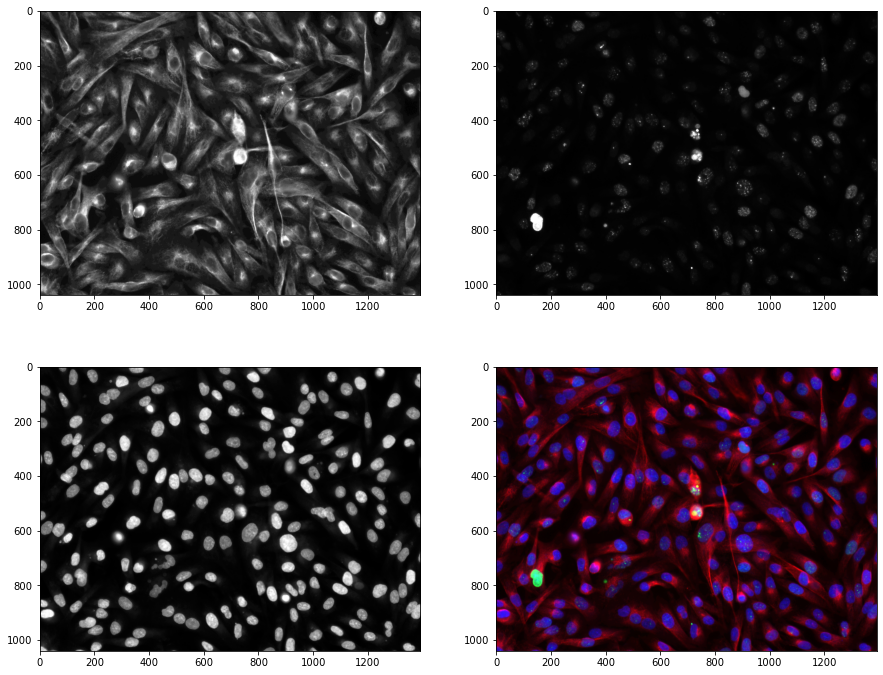

In [4]:
from src.vis_utils import ImageCropper

cell_line = 'mda231'
ch5_path = '%s/%s/hdf5/' % (data_path, plates[cell_line])

ic = ImageCropper('A01', 1, ch5_path)
img = ic.get_image()

fig, axes = plt.subplots(figsize=(15, 12), ncols=2, nrows=2)

axes[0][0].imshow(img[..., 0], cmap='Greys_r')
axes[0][1].imshow(img[..., 1], cmap='Greys_r')
axes[1][0].imshow(img[..., 2], cmap='Greys_r')
axes[1][1].imshow(img)

In [5]:
df_mda231 = plate_data['mda231'].data
mda231_wells = set(df_mda231.well)

df_mda468 = plate_data['mda468'].data
mda468_wells = set(df_mda468.well)

common_wells = mda231_wells.intersection(mda468_wells)

df_pooled = pd.concat([df_mda231[df_mda231.well.isin(common_wells)],
                       df_mda468[df_mda468.well.isin(common_wells)]])

# choose dataset_index in range(60)
dataset_index = 43

# read pre-sampled wells from file
df_wells = pd.read_csv('multi-cell-line/datasets.csv', index_col=0)
fold_wells = sorted(list(df_wells.loc[dataset_index]))

df_fold = df_pooled[df_pooled.well.isin(fold_wells)].copy()
moas = df_fold.moa.unique()

hc_features = list(filter(lambda x : x.startswith('primary') or
                                     x.startswith('secondary') or
                                     x.startswith('tertiary'), df_pooled.columns))

# normalise cell line data
x_mda231 = df_fold[df_fold.cell_line == 'mda231'][hc_features]
x_mda231 = (x_mda231 - np.mean(x_mda231, axis=0)) / np.std(x_mda231, axis=0)

x_mda468 = df_fold[df_fold.cell_line == 'mda468'][hc_features]
x_mda468 = (x_mda468 - np.mean(x_mda468, axis=0)) / np.std(x_mda468, axis=0)

df_fold[hc_features] = np.vstack([x_mda231, x_mda468])

In [6]:
from src.vis_utils import image_crop_training_set

cell_line = 'mda231'
ch5_path = '%s/%s/hdf5/' % (data_path, plates[cell_line])

df = df_fold[df_fold.cell_line == 'mda231']
# df = df_pooled[df_pooled.cell_line == 'mda231']

x_img_mda231 = image_crop_training_set(df, ch5_path, 64, 0.5)

print(x_img_mda231.shape)
print('%.02f Mb' % (sys.getsizeof(x_img_mda231) / float(10 ** 6)))

(11313, 64, 64, 3)
556.06 Mb


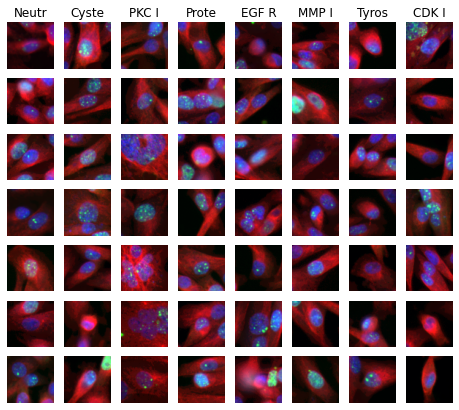

In [7]:
from src.vis_utils import plot_moa_samples

moas = df_fold.moa.unique()
plot_moa_samples(x_img_mda231, df, moas)

In [8]:
cell_line = 'mda468'
ch5_path = '%s/%s/hdf5/' % (data_path, plates[cell_line])

df = df_fold[df_fold.cell_line == 'mda468']

x_img_mda468 = image_crop_training_set(df, ch5_path, 64, 0.5)

print(x_img_mda468.shape)
print('%.02f Mb' % (sys.getsizeof(x_img_mda468) / float(10 ** 6)))

(7549, 64, 64, 3)
371.05 Mb


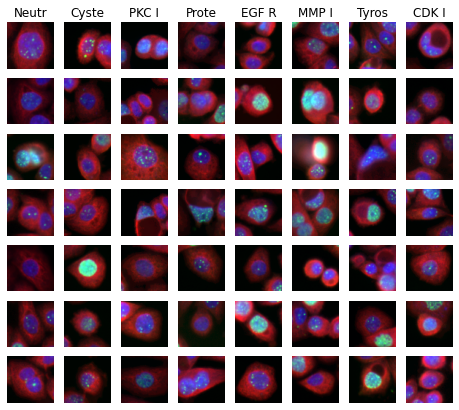

In [9]:
plot_moa_samples(x_img_mda468, df, moas)

# Data generator

In [10]:
x_img_mda468 = np.moveaxis(x_img_mda468, 3, 1)
mda468 = [ x for x in zip(x_img_mda468, df_fold.loc[df_fold.cell_line == 'mda468', 'moa']) ]
x_img_mda231 = np.moveaxis(x_img_mda231, 3, 1)
mda231 = [ x for x in zip(x_img_mda231, df_fold.loc[df_fold.cell_line == 'mda231', 'moa']) ]

In [11]:
from datasets import MultiCellDataset

siamese_dataset = MultiCellDataset(mda468, mda231, transform=None)

RuntimeError: KeyboardInterrupt: 

In [ ]:
import torch
from torch.utils.data import DataLoader
import torchvision

def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

# NN

In [ ]:
from networks import SiameseNet
from losses import ContrastiveLoss

class Config():
    training_dir = "./data/boyd_2019/training/"
    testing_dir = "./data/boyd_2019/testing/"
    train_batch_size = 64
    train_number_epochs = 100

train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [ ]:
from torch import optim

net = SiameseNet().cpu()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

counter = []
loss_history = [] 
iteration_number= 0

In [ ]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cpu(), img1.cpu() , label.cpu()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

/Users/hclimente/miniconda3/envs/laptop/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


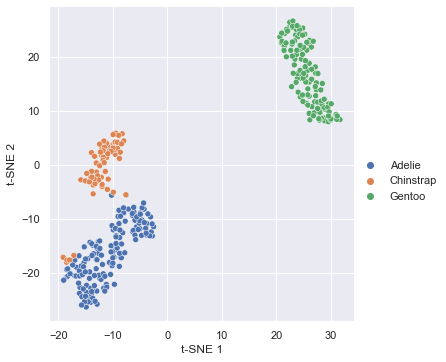

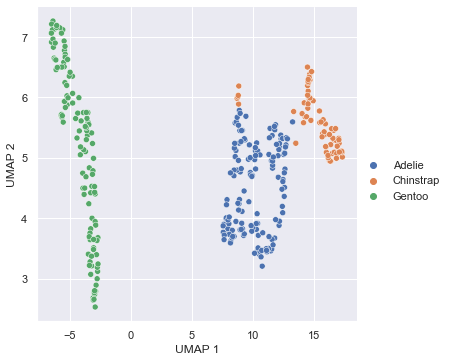

In [12]:
# test viz functions
import pandas as pd
from sklearn.preprocessing import StandardScaler

from viz import tsne,umap

penguins = pd.read_csv("https://github.com/allisonhorst/palmerpenguins/raw/5b5891f01b52ae26ad8cb9755ec93672f49328a8/data/penguins_size.csv")
penguins.head()
penguins = penguins.dropna()
penguins.species_short.value_counts()
penguin_data = penguins[
    [
        "culmen_length_mm",
        "culmen_depth_mm",
        "flipper_length_mm",
        "body_mass_g",
    ]
].values
scaled_penguin_data = StandardScaler().fit_transform(penguin_data)

tsne(scaled_penguin_data, penguins['species_short'].values)
umap(scaled_penguin_data, penguins['species_short'].values)